In [1]:
# =====================================================
# 🖐️ Hand Gesture Recognition - MobileNetV2 Fine-tuned
# =====================================================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
import mlflow
import json

In [2]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000/")
mlflow.set_experiment("MobileNetV2")

<Experiment: artifact_location='mlflow-artifacts:/277566902251080317', creation_time=1763775733699, experiment_id='277566902251080317', last_update_time=1763779290050, lifecycle_stage='active', name='MobileNetV2', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [3]:
# =====================================================
# 📁 Load Dataset
# =====================================================

data_path = "C:\\Users\\Sama\\Downloads\\Hand Gesture\\leapGestRecog\\leapGestRecog"
img_size = 128

X, y, subjects = [], [], []

gesture_folders = [
    '01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb',
    '06_index', '07_ok', '08_palm_moved', '09_c', '10_down'
]

for subject in sorted(os.listdir(data_path)):
    subject_path = os.path.join(data_path, subject)
    if not os.path.isdir(subject_path):
        continue

    for gesture in gesture_folders:
        gesture_path = os.path.join(subject_path, gesture)
        if not os.path.isdir(gesture_path):
            continue

        for img_name in os.listdir(gesture_path):
            img_path = os.path.join(gesture_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))
            X.append(img)
            y.append(gesture)
            subjects.append(subject)

X = np.array(X, dtype="float32")
y = np.array(y)
subjects = np.array(subjects)

print("✅ Total samples:", X.shape[0])


✅ Total samples: 20000


In [4]:
with mlflow.start_run(run_name="Data_Info"):
    # Log dataset parameters
    mlflow.log_param("data_path", data_path)
    mlflow.log_param("img_size", img_size)
    mlflow.log_param("num_classes", len(gesture_folders))
    mlflow.log_param("num_subjects", len(np.unique(subjects)))
    
    # Log dataset metrics
    mlflow.log_metric("num_images_total", X.shape[0])
    
    # Save and log label map as artifact
    label_map = {gesture: idx for idx, gesture in enumerate(gesture_folders)}
    with open("label_map.json", "w") as f:
        json.dump(label_map, f)
    mlflow.log_artifact("label_map.json")


🏃 View run Data_Info at: http://127.0.0.1:5000/#/experiments/277566902251080317/runs/f35625f2ed98430d9d2dc24baab39a86
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/277566902251080317


In [5]:
# =====================================================
# 🧩 Encode Labels
# =====================================================
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded, num_classes=len(np.unique(y)))

In [6]:
# =====================================================
# ✂️ Split by Subjects (No Leakage)
# =====================================================
train_subjects = ["00","01","02","03","04"]
val_subjects   = ["08","06" ,"05"]
test_subjects  = ["09","07"]
print("Subjects in Train:", np.unique(subjects[np.isin(subjects, train_subjects)]))
print("Subjects in Val:", np.unique(subjects[np.isin(subjects, val_subjects)]))
print("Subjects in Test:", np.unique(subjects[np.isin(subjects, test_subjects)]))


X_train = X[np.isin(subjects, train_subjects)]
y_train = y_cat[np.isin(subjects, train_subjects)]

X_val = X[np.isin(subjects, val_subjects)]
y_val = y_cat[np.isin(subjects, val_subjects)]

X_test = X[np.isin(subjects, test_subjects)]
y_test = y_cat[np.isin(subjects, test_subjects)]

print(f"📊 Split done:\nTrain: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Subjects in Train: ['00' '01' '02' '03' '04']
Subjects in Val: ['05' '06' '08']
Subjects in Test: ['07' '09']
📊 Split done:
Train: (10000, 128, 128), Val: (6000, 128, 128), Test: (4000, 128, 128)


In [7]:
# =====================================================
# 🖼️ Ensure correct dimensions
# =====================================================
if X_train.ndim == 3:
    X_train = np.expand_dims(X_train, axis=-1)
    X_val = np.expand_dims(X_val, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)

In [8]:
# =====================================================
# 🎨 Convert grayscale → RGB (3 channels)
# =====================================================
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_val_rgb   = np.repeat(X_val, 3, axis=-1)
X_test_rgb  = np.repeat(X_test, 3, axis=-1)

print("🖼️ Shapes after RGB conversion:")
print("Train:", X_train_rgb.shape)
print("Val:", X_val_rgb.shape)
print("Test:", X_test_rgb.shape)


🖼️ Shapes after RGB conversion:
Train: (10000, 128, 128, 3)
Val: (6000, 128, 128, 3)
Test: (4000, 128, 128, 3)


In [9]:
with mlflow.start_run(run_name="Data_Preprocessing"):
    mlflow.log_param("num_classes", len(np.unique(y)))
    mlflow.log_param("train_subjects", str(train_subjects))
    mlflow.log_param("val_subjects", str(val_subjects))
    mlflow.log_param("test_subjects", str(test_subjects))
    mlflow.log_param("img_height", X_train_rgb.shape[1])
    mlflow.log_param("img_width", X_train_rgb.shape[2])
    mlflow.log_param("num_channels", X_train_rgb.shape[3])
    
    mlflow.log_metric("num_images_total", len(X))
    mlflow.log_metric("num_images_train", len(X_train))
    mlflow.log_metric("num_images_val", len(X_val))
    mlflow.log_metric("num_images_test", len(X_test))
    

🏃 View run Data_Preprocessing at: http://127.0.0.1:5000/#/experiments/277566902251080317/runs/ca3ccd820dc445e5b8c79aa9946fb60e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/277566902251080317


In [10]:
# =====================================================
# ⚙️ Data Generators
# =====================================================

# 🧠 Augmentation متقدم جدًا
aug_params = {
    "rescale": 1./255,
    "rotation_range": 45,
    "width_shift_range": 0.25,
    "height_shift_range": 0.25,
    "shear_range": 0.3,
    "zoom_range": (0.7, 1.4),
    "brightness_range": (0.3, 1.7),
    "channel_shift_range": 40.0,
    "horizontal_flip": True,
    "fill_mode": "nearest"
}

train_datagen = ImageDataGenerator(**aug_params)




test_val_datagen = ImageDataGenerator(rescale=1./255)

train_gen_rgb = train_datagen.flow(X_train_rgb, y_train, batch_size=64, shuffle=True)
val_gen_rgb   = test_val_datagen.flow(X_val_rgb, y_val, batch_size=64, shuffle=False)
test_gen_rgb  = test_val_datagen.flow(X_test_rgb, y_test, batch_size=64, shuffle=False)


In [11]:
with mlflow.start_run(run_name="Augmentation"):
  mlflow.log_params(aug_params)


🏃 View run Augmentation at: http://127.0.0.1:5000/#/experiments/277566902251080317/runs/5d06417c8fc64987a6ea607929b22b20
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/277566902251080317


In [12]:
# =====================================================
# 📞 Callbacks
# =====================================================
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath='best_cnn(20_3).keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]


In [13]:
with mlflow.start_run(run_name="Callbacks"):
  mlflow.log_params({
    "early_stopping_patience": 5,
    "checkpoint_best_only": True,
    "reduce_lr_factor": 0.2,
    "reduce_lr_patience":3,
})


🏃 View run Callbacks at: http://127.0.0.1:5000/#/experiments/277566902251080317/runs/5b1f86fefd2847de9dc12ebbe85f8398
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/277566902251080317


In [14]:
# =====================================================
# 🧠 Build MobileNetV2 Model
# =====================================================
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization

num_classes = len(le.classes_)
base = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

for layer in base.layers[:80]:   # بدلاً من 85
    layer.trainable = False



x = base.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)   # 
x = Dropout(0.6)(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)  
x = Dropout(0.6)(x)
out = Dense(num_classes, activation='softmax')(x)


mobilenet_model = Model(inputs=base.input, outputs=out)

mobilenet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mobilenet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,428,874 (9.27 MB)

 Trainable params: 2,206,858 (8.42 MB)

 Non-trainable params: 222,016 (867.25 KB)

In [16]:
with mlflow.start_run(run_name="Building_Training"):

    # -------------------------------
    # 1️⃣ Log Essential Parameters
    # -------------------------------
    mlflow.log_param("optimizer", "Adam")                 # Optimizer used
    mlflow.log_param("learning_rate", 1e-5)              # Learning rate
    mlflow.log_param("epochs", 20)                        # Total training epochs
    mlflow.log_param("batch_size", 64)                   # Batch size used in generators
    mlflow.log_param("image_shape", X_train_rgb.shape[1:]) # Shape of input images (H, W, C)
    
    # -------------------------------
    # 2️⃣ Train the Model
    # -------------------------------
    history_mobilenet = mobilenet_model.fit(
        train_gen_rgb,
        validation_data=val_gen_rgb,
        epochs=20,
        callbacks=callbacks
    )
    
    # -------------------------------
    # 3️⃣ Log Training Metrics per Epoch
    # -------------------------------
    for i, acc in enumerate(history_mobilenet.history['accuracy']):
        mlflow.log_metric("train_accuracy", acc, step=i+1)
    for i, val_acc in enumerate(history_mobilenet.history['val_accuracy']):
        mlflow.log_metric("val_accuracy", val_acc, step=i+1)
    for i, loss in enumerate(history_mobilenet.history['loss']):
        mlflow.log_metric("train_loss", loss, step=i+1)
    for i, val_loss in enumerate(history_mobilenet.history['val_loss']):
        mlflow.log_metric("val_loss", val_loss, step=i+1)
    

Epoch 1/20
 40/157 ━━━━━━━━━━━━━━━━━━━━ 1:45 898ms/step - accuracy: 0.1498 - loss: 3.7222🏃 View run Building_Training at: http://127.0.0.1:5000/#/experiments/277566902251080317/runs/0723cfb50b494ba59b493bd04f220691
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/277566902251080317


KeyboardInterrupt: 

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 364ms/step - accuracy: 0.7558 - loss: 0.8990

✅ Test Accuracy: 75.58%
💡 Test Loss: 0.8990
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 366ms/step - accuracy: 0.7558 - loss: 0.8990

✅ Test Accuracy: 75.58%
💡 Test Loss: 0.8990
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 445ms/step

📋 Classification Report:
               precision    recall  f1-score   support

      01_palm       0.89      0.99      0.94       400
         02_l       0.45      0.94      0.61       400
      03_fist       0.99      0.19      0.32       400
04_fist_moved       0.57      0.97      0.72       400
     05_thumb       0.87      1.00      0.93       400
     06_index       0.82      0.50      0.62       400
        07_ok       0.98      0.73      0.84       400
08_palm_moved       1.00      0.94      0.97       400
         09_c       0.81      0.77      0.79       400
      10_down       1.00      0.51      0.67       400

     accuracy                           0.76      4000
    macro avg       0.84    

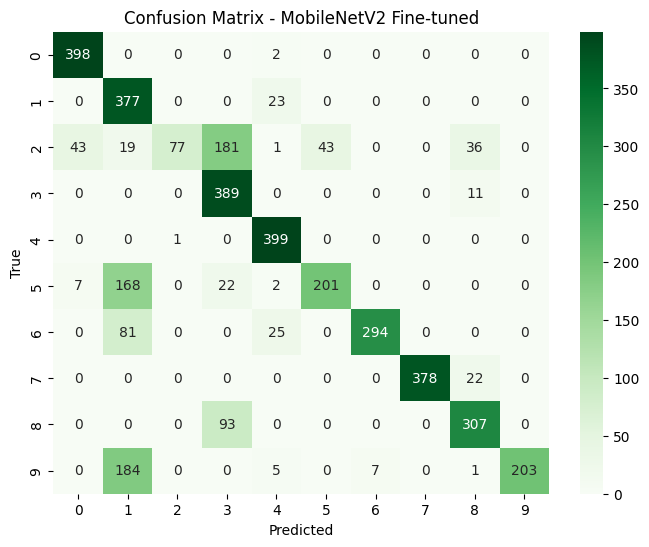

In [ ]:
# =====================================================
# 🧾 Evaluation on Test Set
# =====================================================
test_loss, test_acc = mobilenet_model.evaluate(test_gen_rgb, verbose=1)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"💡 Test Loss: {test_loss:.4f}")

# 🧾 Evaluation on Test Set (بدون double normalization)
test_loss, test_acc = mobilenet_model.evaluate(test_gen_rgb, verbose=1)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"💡 Test Loss: {test_loss:.4f}")

# ✅ استخدمي generator مباشرة للتنبؤ، مش /255.0 تاني
y_pred = mobilenet_model.predict(test_gen_rgb)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - MobileNetV2 Fine-tuned")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



In [ ]:
with mlflow.start_run(run_name="Evaluation"):
  mlflow.log_metric("test_accuracy", test_acc)
  mlflow.log_metric("test_loss", test_loss)



🏃 View run Evaluation at: http://127.0.0.1:5000/#/experiments/277566902251080317/runs/c83090c24e2641c09a007ee04ccfcd55
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/277566902251080317


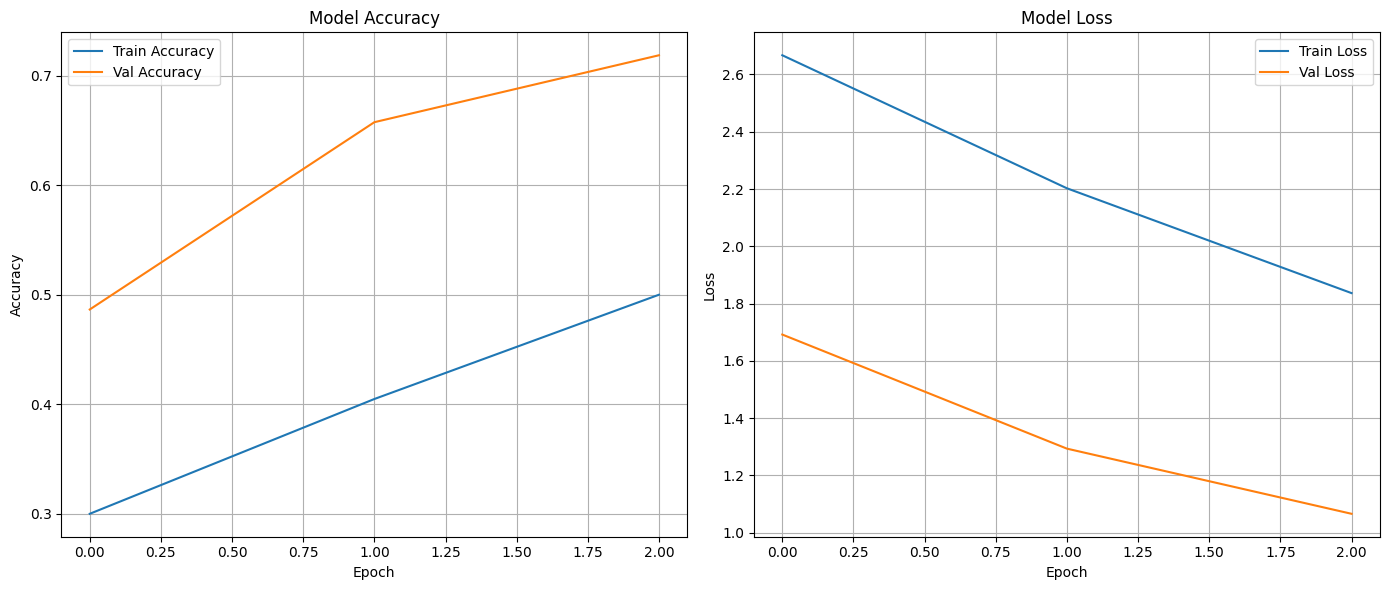

<Figure size 640x480 with 0 Axes>

In [ ]:
# =====================================================
# 📊 Plot Training Curves (Accuracy & Loss)
# =====================================================
import matplotlib.pyplot as plt

# Assuming your fit output is saved as 'history'
hist = history_mobilenet.history

plt.figure(figsize=(14, 6))

# -------- Accuracy Plot --------
plt.subplot(1, 2, 1)
plt.plot(hist['accuracy'], label='Train Accuracy')
plt.plot(hist['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# -------- Loss Plot --------
plt.subplot(1, 2, 2)
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
with mlflow.start_run(run_name="Model"):
   mlflow.tensorflow.log_model(
        mobilenet_model,
        artifact_path="mobilenet_model",
        registered_model_name="MobileNetV2_HandGesture_Model"
    )

2025/11/22 06:44:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/22 06:44:17 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/11/22 06:44:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'MobileNetV2_HandGesture_Model'.
2025/11/22 06:44:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: MobileNetV2_HandGesture_Model, version 1
Created version '1' of model 'MobileNetV2_HandGesture_Model'.


🏃 View run Model at: http://127.0.0.1:5000/#/experiments/277566902251080317/runs/63cfe914ee5b46c7995b1181c3bc1355
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/277566902251080317
